#### In this notebook we will attempt to build a model to identify the probability of a customer churning from a bank. 
#### Customer churn is usually a 'detection' type of problem. This means that there can be severe class imbalance. We will confirm it when we do the exploratory data analysis.
#### Whenever there is such a class imbalance we need to take special care to solve it as a naive 'positive only' classifier can give very good results which won't be very helpful
#### As already stated in the problem we will use AUC - ROC as the measure to evaluate our model performance

#### Approach
1. Import the Data and libraries
2. Perform Exploratory Data Analysis (EDA)
    2.1. Check for null values and take appropriate steps to address them (imputation, removal, etc.).
    2.2. Check for outliers and decide on handling strategies (clipping, transformation, or removal).
    2.3. Explore the distribution of features and the target variable. For imbalanced data, plan strategies like resampling or using specific performance metrics.
    2.4. Check for correlations between features to identify multicollinearity or potential feature interactions.
    2.5. Visualize the data with plots (histograms, scatter plots, box plots) for a better understanding of distributions and relationships.

3. Feature Engineering
    3.1. Create/transform features based on domain knowledge and insights from EDA.
    3.2. Consider encoding categorical variables and handling high-cardinality features.
    3.3. Experiment with creating interaction terms if there is evidence or hypothesis of interaction effects.

4. Shortlist Models for the Use Case
    4.1. Based on the problem type (classification, regression), list down potential models.
    4.2. Consider starting with simpler models and then move to more complex ones.

5. Standardize/Normalize Features if Required
    5.1. Decide based on model selection. For instance, tree-based models don't require standardization.
    
6. Split the Data into Training and Validation Sets
    6.1. Consider using stratified sampling if the target variable is imbalanced.
    
7. Model Training and Hyperparameter Tuning
    7.1. Train the shortlisted models on the training set.
    7.2. Perform hyperparameter tuning using techniques like Grid Search or Randomized Search, especially for complex models.
    7.3. Implement cross-validation to evaluate model performance.
    
8. Model Evaluation and Selection
    8.1. Evaluate models based on appropriate metrics (e.g., AUC-ROC for classification with imbalanced data).
    8.2. Consider model interpretability and complexity alongside performance.

9. Finalize the Model and Create a Prediction Pipeline

    9.1. Choose the final model based on evaluation.
    9.2. Create a pipeline that includes preprocessing and the chosen model.
    9.3. Train the pipeline on the entire training data (training + validation).
10. Predict on the Test Set and Prepare the Output

    10.1. Use the pipeline to predict on the test set.
    10.2. Format the output as required (e.g., submission file for a competition, report for stakeholders).
11. Documentation and Reporting

    11.1. Document the modeling process, decisions made, and rationale.
    11.2. Prepare a final report or presentation summarizing the findings, model performance, and any business insights or recommendations.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# importing libraries to do data visualization

from matplotlib import pyplot as plt
import seaborn as sns

# importing libraries to perform statistical analysis

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


### Step 1: Import the data

In [2]:
# Storing the training and test data filepath in a variable for easy access
train_data_filepath='''/kaggle/input/playground-series-s4e1/train.csv'''
test_data_filepath='''/kaggle/input/playground-series-s4e1/test.csv'''

In [3]:
# import the data into pandas dataframe
df_train=pd.read_csv(train_data_filepath, index_col="id")
df_test=pd.read_csv(test_data_filepath)

In [4]:
# let's check the first few rows of the train data
# this will tell us whether the import went through fine and how do the columns look like
df_train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


### Step 2: Exploratory Data Analysis

In [6]:
# checking the size
df_train.shape

(165034, 13)

In [7]:
# checking the different column names
df_train.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

#### Checking null-values

In [8]:
# getting the information about the columns
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


#### There are a total of 165,034 rows and each of the attribute has the same number of non-null values. Hence, we don't have a problem of null values here

#### Outlier detection
##### To begin let's look at some basic stats of the data

In [9]:
df_train[df_train.columns[1:]].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


##### A look at the min, max, mean and standard deviation reveals that no features seems to have any outliers 

#### Let us check the disctribition of the data

array([[<Axes: title={'center': 'CustomerId'}>,
        <Axes: title={'center': 'CreditScore'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Tenure'}>,
        <Axes: title={'center': 'Balance'}>,
        <Axes: title={'center': 'NumOfProducts'}>],
       [<Axes: title={'center': 'HasCrCard'}>,
        <Axes: title={'center': 'IsActiveMember'}>,
        <Axes: title={'center': 'EstimatedSalary'}>],
       [<Axes: title={'center': 'Exited'}>, <Axes: >, <Axes: >]],
      dtype=object)

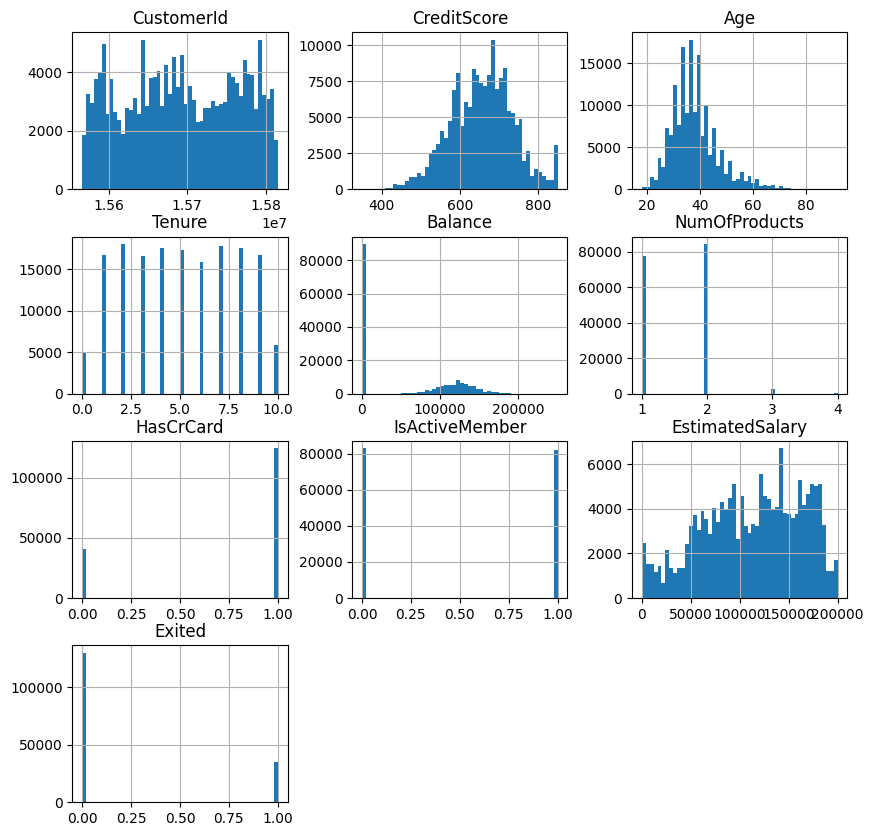

In [10]:
df_train.hist(figsize=(10,10), bins=50)

<Axes: xlabel='Gender', ylabel='count'>

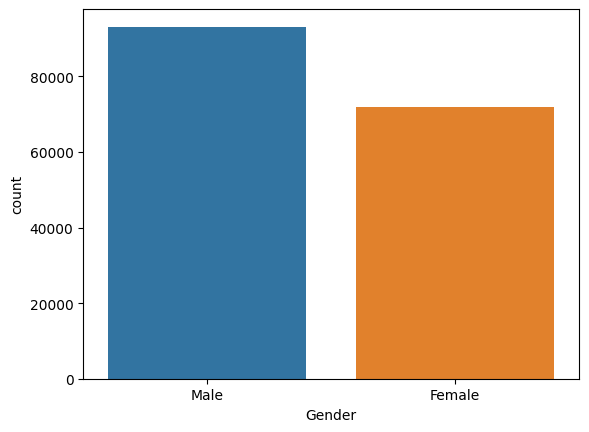

In [11]:
# let's check the categorical variables as well
sns.countplot(x='Gender', data=df_train)

<Axes: xlabel='Geography', ylabel='count'>

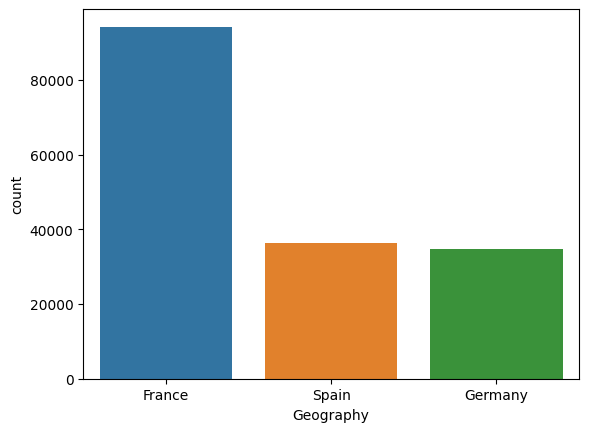

In [12]:
sns.countplot(x="Geography",data=df_train)

#### Quantifying the class imbalance

In [13]:
minority_class, majority_class=(df_train["Exited"].value_counts().iloc[1],df_train["Exited"].value_counts().iloc[0])
minority_class,majority_class

(34921, 130113)

In [14]:
imbalance=minority_class/(minority_class+majority_class)
imbalance

0.21159882206090866

#### We can clearly see that the minority class represents ~ 21% of the dataset.
#### This is not a severe imbalance but still it is an imbalance we should keep in mind.
#### Additionally, we also note that "Balance" has a lot of zeros and then a normal looking distribution. We also see that the "NumOfProds" has very less 3 and 4

<Axes: >

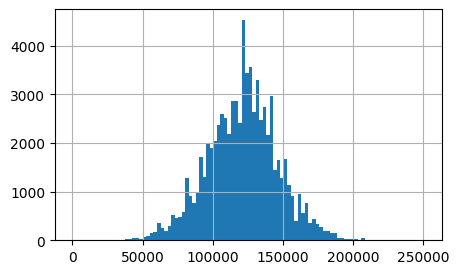

In [15]:
df_train["Balance"][df_train["Balance"]!=0].hist(figsize=(5,3),bins=100)

#### Keeping the above in mind we will engineer a binary variable which will indicate whether "Balances" ==0

### Let us recap some of our understanding of the data before we go on to engineer some features
1. No null values
2. No outliers
3. Create binary for "Balance"
4. We will create a new feature by creating "NumOfProducts"=2,3, or 4

### Step 3: Feature Engineering

In [16]:
df_train["x_Balance"]=0
df_train.loc[df_train["Balance"]!=0,"x_Balance"]=1
df_train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,x_Balance
id,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0


In [17]:
df_train["NumOfProducts"].value_counts()

NumOfProducts
2    84291
1    77374
3     2894
4      475
Name: count, dtype: int64

In [18]:
# we will merge the 3s and 4s as they are very sparse
df_train["NumOfProdBins"] = np.where(df_train["NumOfProducts"] == 1, "1", "2-4")
df_train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,x_Balance,NumOfProdBins
id,,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,2-4
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,2-4
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,2-4
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1,1
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,2-4


#### Next we will do the one hot encoding of all the categorical variables

In [19]:
cols_to_encode=["Geography","Gender","NumOfProdBins"]

In [20]:
df_train=pd.get_dummies(df_train, columns=cols_to_encode,dtype=int)
df_train.head()

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,x_Balance,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProdBins_1,NumOfProdBins_2-4
id,,,,,,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,1,0,0,0,1,0,1
1,15749177,Okwudiliolisa,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1,0,0,0,1,0,1
2,15694510,Hsueh,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,1,0,0,0,1,0,1
3,15741417,Kao,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1,1,0,0,0,1,1,0
4,15766172,Chiemenam,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0,0,1,0,1,0,1


#### We will use both undersampling and SMOTE methods to reduce the data imbalance

In [21]:
X_train = df_train.drop('Exited', axis=1) 
y_train = df_train['Exited']

In [22]:
X_train.head()

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x_Balance,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProdBins_1,NumOfProdBins_2-4
id,,,,,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,1,0,0,0,1,0,1
1,15749177,Okwudiliolisa,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,1,0,0,0,1,0,1
2,15694510,Hsueh,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,1,0,0,0,1,0,1
3,15741417,Kao,581,34.0,2,148882.54,1,1.0,1.0,84560.88,1,1,0,0,0,1,1,0
4,15766172,Chiemenam,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0,1,0,1,0,1


### Step 4: Models under consideration: Our final output is supposed to be probabilities. Logistic regression is an obvious first choice to generate classification probabilities. Apart from that we will use tree based approaches which are intrisically not sensitive to class imbalance. Finally we will use a neural network

In [23]:
X=X_train.drop(columns=['CustomerId','Surname'])
y=y_train

In [24]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x_Balance,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProdBins_1,NumOfProdBins_2-4
id,,,,,,,,,,,,,,,,
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,1,0,0,0,1,0,1
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,1,0,0,0,1,0,1
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,1,0,0,0,1,0,1
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,1,1,0,0,0,1,1,0
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0,1,0,1,0,1


In [25]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=55, stratify=y)

### Lets start modelling

In [26]:
# logistic regression
model_logistic=LogisticRegression()
model_logistic.fit(train_X,train_y)

LogisticRegression()

In [27]:
# Make predictions
y_probs_logistic = model_logistic.predict_proba(val_X)[:, 1]  # Probabilities of the positive class

In [28]:
def AUC(y_test,y_probs):
    auc = roc_auc_score(y_test, y_probs)
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, color='orange', label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    return auc

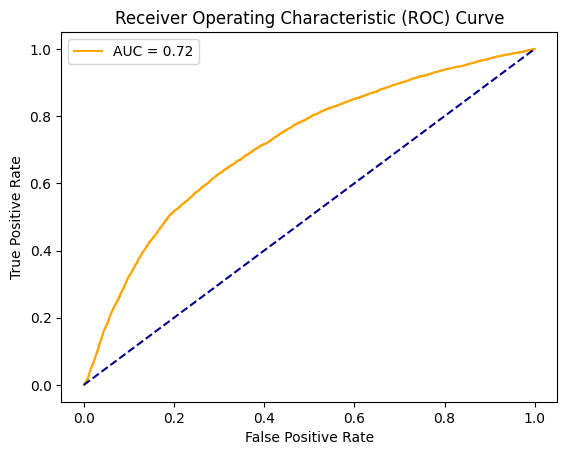

0.7159669398103599

In [29]:
AUC(val_y,y_probs_logistic)

In [30]:
# undersample
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=55)
X_train_under, y_train_under = undersample.fit_resample(train_X, train_y)

# SMOTE
smote = SMOTE(random_state=55)
X_train_smote, y_train_smote = smote.fit_resample(train_X, train_y)

In [31]:
model_under_sample=model_logistic.fit(X_train_under,y_train_under)
model_smote=model_logistic.fit(X_train_smote,y_train_smote)

In [32]:
# Make predictions
y_probs_under = model_under_sample.predict_proba(val_X)[:, 1]  # Probabilities of the positive class

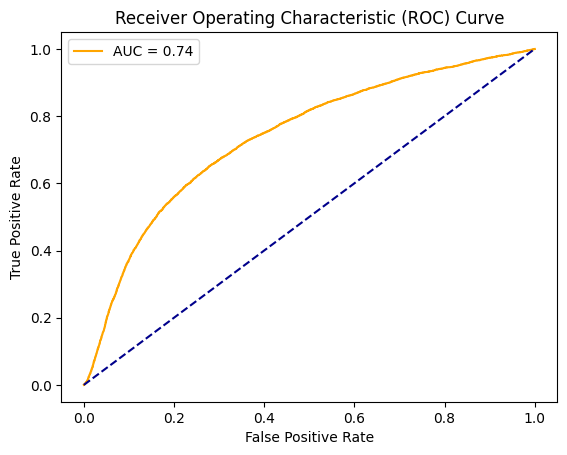

0.738291978824442

In [33]:
AUC(val_y,y_probs_under)

In [34]:
# Make predictions
y_probs_smote = model_smote.predict_proba(val_X)[:, 1]  # Probabilities of the positive class

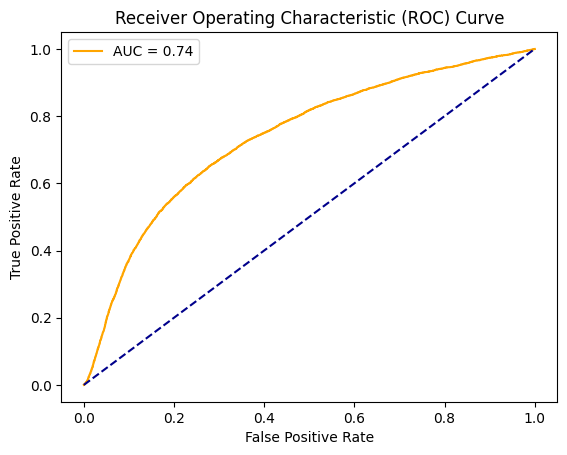

0.738291978824442

In [35]:
AUC(val_y,y_probs_smote)

### Tree based approaches

In [36]:
train_X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x_Balance,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProdBins_1,NumOfProdBins_2-4
id,,,,,,,,,,,,,,,,
78119,633,39.0,5,0.00,2,0.0,1.0,126836.88,0,1,0,0,0,1,0,1
106920,835,25.0,8,0.00,2,0.0,0.0,138882.95,0,1,0,0,0,1,0,1
49171,604,37.0,7,0.00,2,1.0,0.0,162087.82,0,0,0,1,1,0,0,1
142187,792,39.0,6,128262.71,1,1.0,0.0,81270.99,1,0,1,0,0,1,1,0
21269,632,38.0,9,0.00,2,1.0,0.0,62903.83,0,1,0,0,0,1,0,1


In [37]:
# a function to segregate the numerical and binary variables
def numerical_dataframe(df):
    binary_cols = [col for col in df.columns if df[col].dropna().value_counts().index.isin([0, 1]).all()]
    numerical_cols = [col for col in df.columns if col not in binary_cols]
    return df[numerical_cols],df[binary_cols]

In [38]:
df_numerical=numerical_dataframe(df_train)[0]
df_numerical.head()

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
id,,,,,,,,
0,15674932,Okwudilichukwu,668,33.0,3,0.00,2,181449.97
1,15749177,Okwudiliolisa,627,33.0,1,0.00,2,49503.50
2,15694510,Hsueh,678,40.0,10,0.00,2,184866.69
3,15741417,Kao,581,34.0,2,148882.54,1,84560.88
4,15766172,Chiemenam,716,33.0,5,0.00,2,15068.83


In [39]:
df_numerical=df_numerical.drop(columns=["CustomerId","Surname"])
df_numerical.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
id,,,,,,
0,668,33.0,3,0.00,2,181449.97
1,627,33.0,1,0.00,2,49503.50
2,678,40.0,10,0.00,2,184866.69
3,581,34.0,2,148882.54,1,84560.88
4,716,33.0,5,0.00,2,15068.83


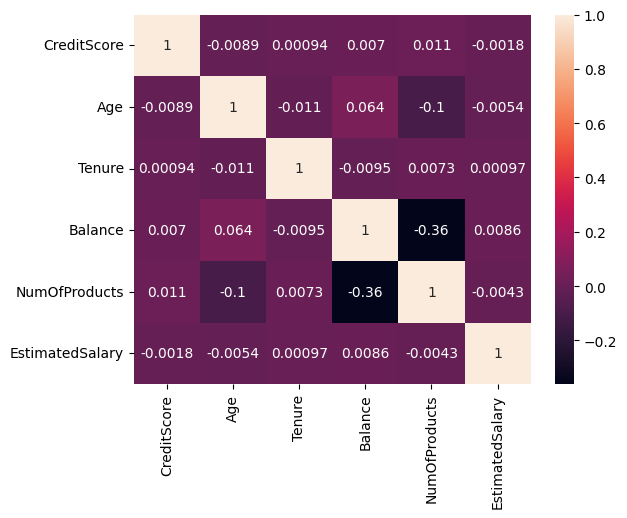

In [40]:
corr_matrix=df_numerical.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

#### Correlations among various numercal variables is very low

#### Let's engineer an additional features. Balance to salary ratio - This could give insights into how much of their estimated salary customers are keeping in their bank accounts. It might indicate the level of trust and reliance a customer has on the bank.

In [41]:
X = df_train.drop(['Exited','CustomerId','Surname'], axis=1)
y = df_train['Exited']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=55, stratify=y)

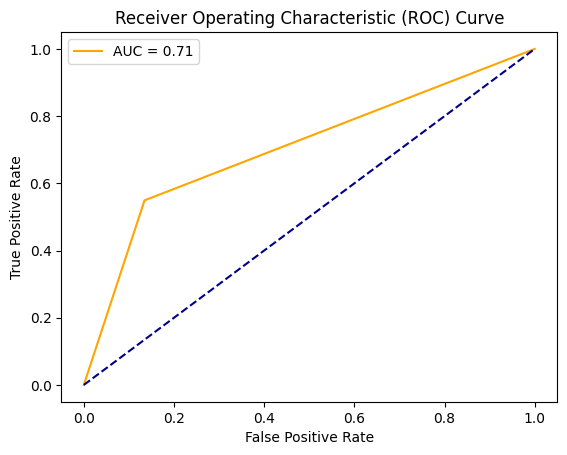

0.7073396231036965

In [42]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Fit the model
dt.fit(X_train, y_train)
y_probs = dt.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class
AUC(y_val,y_probs)

In [43]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold


# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(dt, param_grid, cv=stratified_kfold, scoring='roc_auc', n_jobs=-1)

# Fit Grid Search to the data
grid_search.fit(X_train, y_train)

# Find the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")


Best parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}


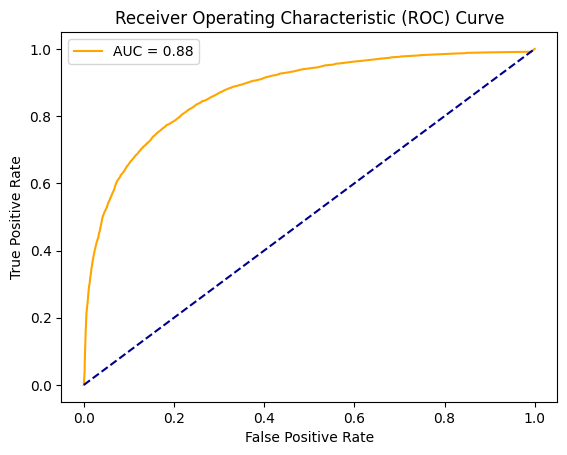

0.8752005011075099

In [44]:
# Build the model with best parameters
dt_best = DecisionTreeClassifier(**best_params, random_state=55)
dt_best.fit(X_train, y_train)

# Predict and evaluate
y_probs_best = dt_best.predict_proba(X_val)[:, 1]
AUC(y_val, y_probs_best)

In [45]:
feature_importances = dt_best.feature_importances_

# Create a DataFrame for visualization
feature_names = X_train.columns
importances = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importances_sorted = importances.sort_values(by='Importance', ascending=False)

# Display
print(importances_sorted)
# print(importances_sorted.sum())

              Feature  Importance
1                 Age    0.394821
4       NumOfProducts    0.262461
6      IsActiveMember    0.098441
3             Balance    0.070993
15  NumOfProdBins_2-4    0.064838
10  Geography_Germany    0.036280
7     EstimatedSalary    0.018680
0         CreditScore    0.018437
12      Gender_Female    0.016887
13        Gender_Male    0.009660
2              Tenure    0.005977
5           HasCrCard    0.001767
11    Geography_Spain    0.000348
8           x_Balance    0.000283
9    Geography_France    0.000127
14    NumOfProdBins_1    0.000000


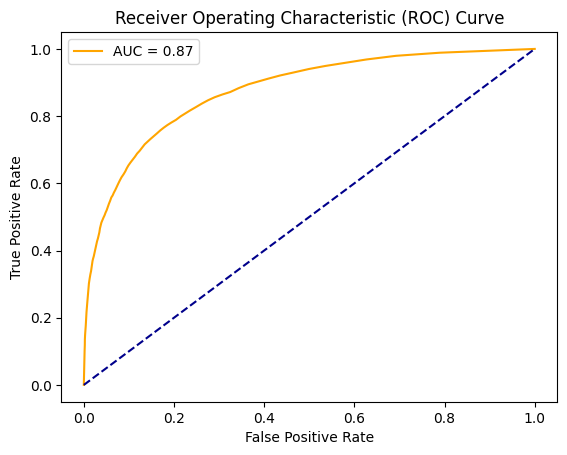

0.8749452776134813

In [46]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=55)
rf.fit(X_train, y_train)
y_probs_rf = rf.predict_proba(X_val)[:, 1]
AUC(y_val,y_probs_rf)

In [47]:
param_grid_rf = {
    'n_estimators': [25, 50, 75],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

In [48]:
# hyperparameter tuning

# Stratified K-Fold for imbalanced dataset
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=55)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, 
                              cv=stratified_kfold, scoring='roc_auc', n_jobs=-1, verbose=2)

grid_search_rf.fit(X_train, y_train)

print("Best parameters found: ", grid_search_rf.best_params_)
print("Best AUC-ROC score found: ", grid_search_rf.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   3.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   6.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=75; total time=   9.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=75; total time=  10.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   6.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=75; total time=   9.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=25; total time=   3.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=25; total time=   3.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   6.9s
[CV] END max_depth=5, min_samples_leaf=1, min_

In [49]:
best_params_rf = grid_search_rf.best_params_
rf_best = RandomForestClassifier(**best_params_rf, random_state=55)
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=6, n_estimators=75,
                       random_state=55)

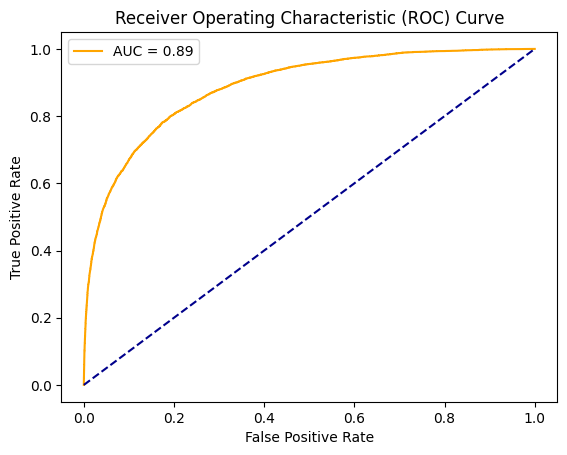

0.8872705357261941

In [50]:
y_probs_rf_best = rf_best.predict_proba(X_val)[:, 1]
AUC(y_val, y_probs_rf_best)

#### XG Boost

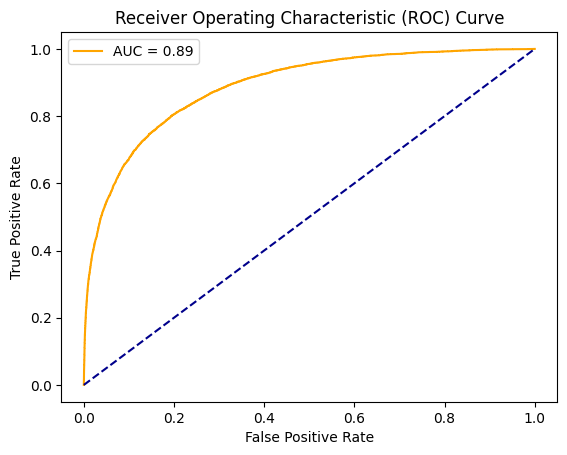

0.8874761346458916

In [51]:
from xgboost import XGBClassifier
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
xgb = XGBClassifier(random_state=55, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_probs_xgb = xgb.predict_proba(X_val)[:, 1]
AUC(y_val,y_probs_xgb)

In [52]:
# hyperparameter tuning
param_grid_xgb = {
'max_depth': [3, 5, 7],
'n_estimators': [100, 200, 300],
'learning_rate': [0.01, 0.1, 0.2]
}

In [53]:
grid_search_xgb = GridSearchCV(xgb, param_grid=param_grid_xgb,cv=stratified_kfold, scoring='roc_auc', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=55, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importanc...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=55, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc')

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


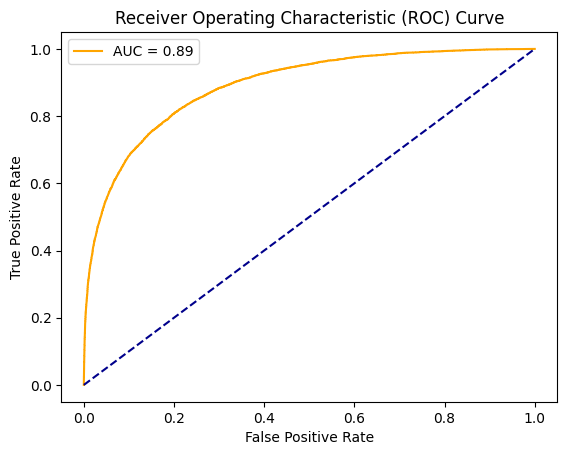

0.8894530843695014

In [54]:
best_params_xgb = grid_search_xgb.best_params_
print(f"Best parameters for XGBoost: {best_params_xgb}")
# Build the model with best parameters
xgb_best = XGBClassifier(**best_params_xgb, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_best.fit(X_train, y_train)

# Predict and evaluate
y_probs_xgb_best = xgb_best.predict_proba(X_val)[:, 1]
AUC(y_val,y_probs_xgb_best)

### Neural network based approach

In [55]:
# before applying a neural network, let us standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numerical_cols=["CreditScore","Age","Tenure","Balance","EstimatedSalary"]
binary_cols=[col for col in train_X if col not in numerical_cols]

X_train_scaled=train_X.copy()
X_train_scaled[numerical_cols]=scaler.fit_transform(train_X[numerical_cols])

X_train_scaled.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x_Balance,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProdBins_1,NumOfProdBins_2-4
id,,,,,,,,,,,,,,,,
78119,-0.292537,0.097498,-0.007020,-0.882414,2,0.0,1.0,0.284176,0,1,0,0,0,1,0,1
106920,2.228371,-1.481950,1.061568,-0.882414,2,0.0,0.0,0.523294,0,1,0,0,0,1,0,1
49171,-0.654449,-0.128138,0.705372,-0.882414,2,1.0,0.0,0.983916,0,0,0,1,1,0,0,1
142187,1.691742,0.097498,0.349176,1.158929,1,1.0,0.0,-0.620318,1,0,1,0,0,1,1,0
21269,-0.305016,-0.015320,1.417764,-0.882414,2,1.0,0.0,-0.984911,0,1,0,0,0,1,0,1


In [56]:
X_val_scaled=val_X.copy()
X_val_scaled[numerical_cols]=scaler.transform(val_X[numerical_cols])
X_val_scaled.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x_Balance,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProdBins_1,NumOfProdBins_2-4
id,,,,,,,,,,,,,,,,
49467,0.256572,-1.143497,-0.007020,1.258174,1,1.0,1.0,0.972638,1,1,0,0,1,0,1,0
113950,-1.141159,3.143576,0.349176,-0.882414,2,1.0,1.0,-1.210197,0,0,0,1,0,1,0,1
44996,-0.142780,-0.353773,-1.075608,0.332214,2,0.0,1.0,1.237688,1,0,1,0,0,1,0,1
35978,0.281531,2.466669,0.705372,-0.882414,2,1.0,1.0,0.249035,0,1,0,0,0,1,0,1
160244,-1.216037,0.435951,-1.075608,-0.882414,2,0.0,0.0,0.179078,0,1,0,0,0,1,0,1


In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(train_y, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float32)
y_val_tensor = torch.tensor(val_y.values, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

In [58]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(train_X.shape[1], 10)
#         self.dropout1 = nn.Dropout(0.5)  # Dropout layer
        self.fc2 = nn.Linear(10, 5)
#         self.dropout2 = nn.Dropout(0.5)  # Another dropout layer
        self.fc3 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
#         x = self.dropout1(x)  # Apply dropout
        x = F.relu(self.fc2(x))
#         x = self.dropout2(x)  # Apply dropout
        x = torch.sigmoid(self.fc3(x))
        return x

net = Net()

In [59]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

In [60]:
y_probs = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = net(inputs)
        y_probs.extend(outputs.squeeze().numpy())

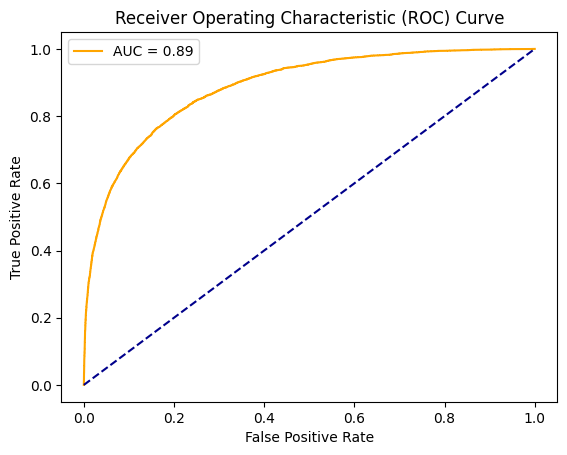

0.8870168280953683

In [61]:
AUC(val_y,y_probs)